# Import Libraries

In [2]:
import time
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_data = datasets.MNIST(root="./mnist", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./mnist", train=False, download=True, transform=transform)

In [6]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Visualization

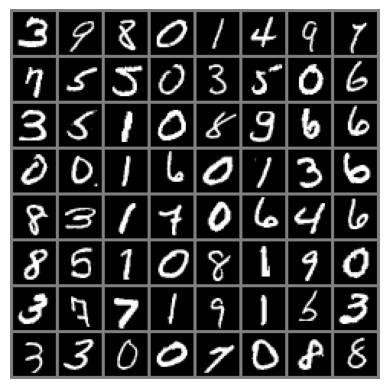

In [7]:
data_iter = iter(train_dataloader)
images, _ = next(data_iter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap="gray")
    plt.axis("off")
    plt.show()

imshow(make_grid(images, nrow=8))

# Highway Network

In [44]:
class HighwayNetwork(nn.Module):
    def __init__(self, input_size, output_size, gate_bias=-2):
        super(HighwayNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.normal_layers = nn.ModuleList([
            nn.Linear(input_size, input_size),
            nn.Linear(input_size, input_size),
            nn.Linear(input_size, input_size),
            nn.Linear(input_size, input_size),
            nn.Linear(input_size, input_size),
        ])

        self.gate_layers = nn.ModuleList([
            nn.Linear(input_size, input_size, bias=True),
            nn.Linear(input_size, input_size, bias=True),
            nn.Linear(input_size, input_size, bias=True),
            nn.Linear(input_size, input_size, bias=True),
            nn.Linear(input_size, input_size, bias=True),
        ])

        for i in range(len(self.gate_layers)):
            self.gate_layers[i].bias.data.fill_(gate_bias)
        
        self.output_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        for i in range(len(self.normal_layers)):
            normal_output = F.relu(self.normal_layers[i](x))
            gate_output = F.sigmoid(self.gate_layers[i](x))
            x = gate_output * normal_output + (1 - gate_output) * x

        x = F.softmax(self.output_layer(x), dim=1)
        return x

In [45]:
model = HighwayNetwork(input_size=784, output_size=10)
model.to(device)

HighwayNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (normal_layers): ModuleList(
    (0-4): 5 x Linear(in_features=784, out_features=784, bias=True)
  )
  (gate_layers): ModuleList(
    (0-4): 5 x Linear(in_features=784, out_features=784, bias=True)
  )
  (model): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): Linear(in_features=784, out_features=784, bias=True)
    (2): Linear(in_features=784, out_features=784, bias=True)
    (3): Linear(in_features=784, out_features=784, bias=True)
    (4): Linear(in_features=784, out_features=784, bias=True)
    (5): Linear(in_features=784, out_features=784, bias=True)
    (6): Linear(in_features=784, out_features=784, bias=True)
    (7): Linear(in_features=784, out_features=784, bias=True)
    (8): Linear(in_features=784, out_features=784, bias=True)
    (9): Linear(in_features=784, out_features=784, bias=True)
  )
  (output_layer): Linear(in_features=784, out_features=10, bias=True)
)

# Train

In [46]:
losses = []

In [47]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [48]:
criterion = nn.NLLLoss()

In [49]:
epochs = 10

In [50]:
for epoch in range(epochs):
    total_loss = 0
    for data, label in train_dataloader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    losses.append(total_loss / len(train_dataloader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_dataloader):.4f}")

Epoch 1/10, Loss: -0.2491
Epoch 2/10, Loss: -0.5101
Epoch 3/10, Loss: -0.6210
Epoch 4/10, Loss: -0.6636
Epoch 5/10, Loss: -0.6859
Epoch 6/10, Loss: -0.7320
Epoch 7/10, Loss: -0.7571
Epoch 8/10, Loss: -0.7699
Epoch 9/10, Loss: -0.7786
Epoch 10/10, Loss: -0.7852


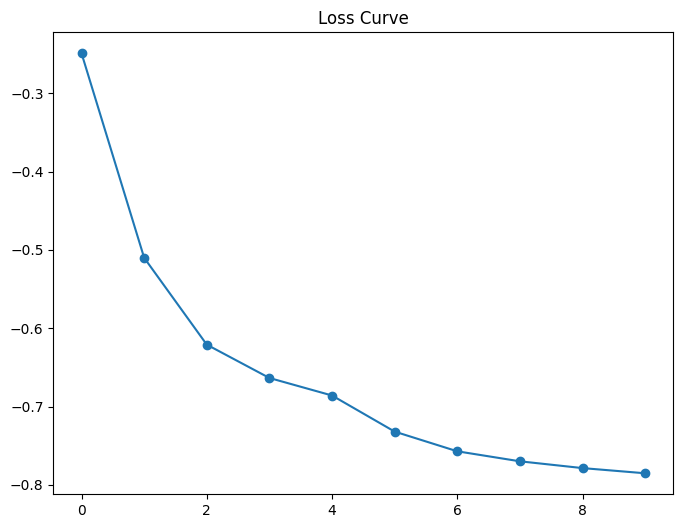

In [51]:
plt.figure(figsize=(8, 6))
plt.title("Loss Curve")
plt.plot(range(epochs), losses, marker="o")
plt.show()

# Results

In [52]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
correct_pred = {class_name: 0 for class_name in classes}
total_pred = {class_name: 0 for class_name in classes}

In [53]:
with torch.no_grad():
    model.eval()

    for data in test_dataloader:
        inputs = data[0].to(device)
        labels = data[1].to(device)

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

In [54]:
for class_name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[class_name]
    print(f'Accuracy for class: {class_name} is {accuracy:.2f} %')

Accuracy for class: 0 is 98.16 %
Accuracy for class: 1 is 97.09 %
Accuracy for class: 2 is 85.56 %
Accuracy for class: 3 is 90.50 %
Accuracy for class: 4 is 92.06 %
Accuracy for class: 5 is 0.00 %
Accuracy for class: 6 is 95.09 %
Accuracy for class: 7 is 89.40 %
Accuracy for class: 8 is 86.76 %
Accuracy for class: 9 is 86.72 %


In [55]:
total_accuracy = 100 * float(np.sum(list(correct_pred.values())) / np.sum(list(total_pred.values())))
print(f'Total Accuracy: {total_accuracy:.2f} %')

Total Accuracy: 83.15 %
